In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from datetime import datetime, timedelta
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

In [7]:
# 下载必要的nltk数据
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [8]:
# Read CSV files
print("\nReading CSV files...")
try:
    # Read the first CSV file
    file1_path = '/content/dataset_youtube-comments-scraper_2025-06-17_06-57-22-932.csv'
    df1 = pd.read_csv(file1_path)
    print(f"Successfully read {len(df1)} records from the first file")

    # Read the second CSV file
    file2_path = '/content/dataset_youtube-comments-scraper_2025-06-17_07-02-35-990.csv'  # Replace with your second file path
    df2 = pd.read_csv(file2_path)
    print(f"Successfully read {len(df2)} records from the second file")

except FileNotFoundError as e:
    print(f"Error: File not found - {e.filename}")
    print("Please ensure the CSV file exists in the specified directory")
    exit()

# Merge the two DataFrames
print("\nMerging the two datasets...")
data = pd.concat([df1, df2], ignore_index=True)
print(f"Successfully merged {len(merged_df)} records")


Reading CSV files...
Successfully read 993 records from the first file
Successfully read 1459 records from the second file

Merging the two datasets...
Successfully merged 2452 records


In [9]:
# 数据预处理函数
def preprocess_text(text):
    # 移除URL
    text = re.sub(r'http\S+', '', text)
    # 移除特殊字符和表情符号
    text = re.sub(r'[^\w\s]', '', text)
    # 转换为小写
    text = text.lower()
    # 分词
    tokens = word_tokenize(text)
    # 移除停用词
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # 词形还原
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # 移除单个字符
    tokens = [word for word in tokens if len(word) > 1]
    return ' '.join(tokens)

# 处理发布时间
def convert_time(text):
    now = datetime.now()
    if 'day' in text:
        days = int(re.search(r'\d+', text).group())
        return now - timedelta(days=days)
    elif 'week' in text:
        weeks = int(re.search(r'\d+', text).group())
        return now - timedelta(weeks=weeks)
    else:
        return now  # 默认返回当前时间

# 应用预处理
data['processed_comment'] = data['comment'].apply(preprocess_text)
data['date'] = data['publishedTimeText'].apply(convert_time)
data['week'] = data['date'].apply(lambda x: x.isocalendar()[1])  # 提取周数

In [11]:
data.head()

,author,authorIsChannelOwner,cid,comment,commentsCount,hasCreatorHeart,pageUrl,publishedTimeText,replyCount,replyToCid,title,type,videoId,voteCount,processed_comment,date,week
0,@bobaaamilk04,False,UgwIRq13DwTSLMIBrPR4AaABAg,infold pls restuin q dgn ayel,993,False,https://www.youtube.com/watch?v=xMR9tY3XfaY,22 hours ago,0,NaN,Love and Deepspace | [Spring and Flowers] Spri...,comment,xMR9tY3XfaY,1,infold pls restuin dgn ayel,2025-06-19 03:52:08.717134,25
1,@sy93xx56,False,Ugy1AetoJPknKCL6IEt4AaABAg,I keep coming back to this 😭,993,False,https://www.youtube.com/watch?v=xMR9tY3XfaY,1 day ago,0,NaN,Love and Deepspace | [Spring and Flowers] Spri...,comment,xMR9tY3XfaY,1,keep coming back,2025-06-18 03:52:08.717140,25
2,@airitodoroki5114,False,UgzYG00-bfJ9HKvXEfV4AaABAg,"""Put this on Spotify pleaseeeee"" \nMe who uses...",993,False,https://www.youtube.com/watch?v=xMR9tY3XfaY,1 day ago,0,NaN,Love and Deepspace | [Spring and Flowers] Spri...,comment,xMR9tY3XfaY,2,put spotify pleaseeeee us youtube music relate,2025-06-18 03:52:08.717234,25
3,@ghostdrargon9202,False,Ugw59mRgooM9qphUl7N4AaABAg,Si have you considered Spotify,993,False,https://www.youtube.com/watch?v=xMR9tY3XfaY,2 days ago,0,NaN,Love and Deepspace | [Spring and Flowers] Spri...,comment,xMR9tY3XfaY,0,si considered spotify,2025-06-17 03:52:08.717239,25
4,@mawquewee,False,UgzQEzmNGsObysbZk2t4AaABAg,still waiting for a spotify release pleaseee,993,False,https://www.youtube.com/watch?v=xMR9tY3XfaY,2 days ago,0,NaN,Love and Deepspace | [Spring and Flowers] Spri...,comment,xMR9tY3XfaY,0,still waiting spotify release pleaseee,2025-06-17 03:52:08.717241,25


Topic analysis for all comments:
Topic 1: main, story, spotify, update, pls, yes, sylus, need, finally, oh
Topic 2: zayne, omg, sylus, im, gun, good, look, infold, thank, snowcrow
Topic 3: song, love, like, im, beautiful, game, barbie, time, feel, vibe

Topic analysis by time window:

Topics for Week 21:
Topic 1: zayne, sylus, main, story, im, update, gun, look, oh, finally
Topic 2: omg, love, game, infold, update, need, dont, like, dawnbreaker, screaming

Topics for Week 22:
Topic 1: spotify, story, song, going, main, version, sylus, know, zayne, make
Topic 2: story, really, sylus, like, love, mc, main, song, character, zaynes

Topics for Week 23:
Topic 1: main, like, story, im, update, got, wouldnt, guy, released, feel
Topic 2: spotify, zayne, lagu, sylus, singing, suka, ini, piano, xavier, love

Topics for Week 24:
Topic 1: love, song
Topic 2: song, love

Topics for Week 25:
Topic 1: zayne, sylus, main, omg, story, im, update, pls, yes, oh
Topic 2: song, love, like, spotify, need, b

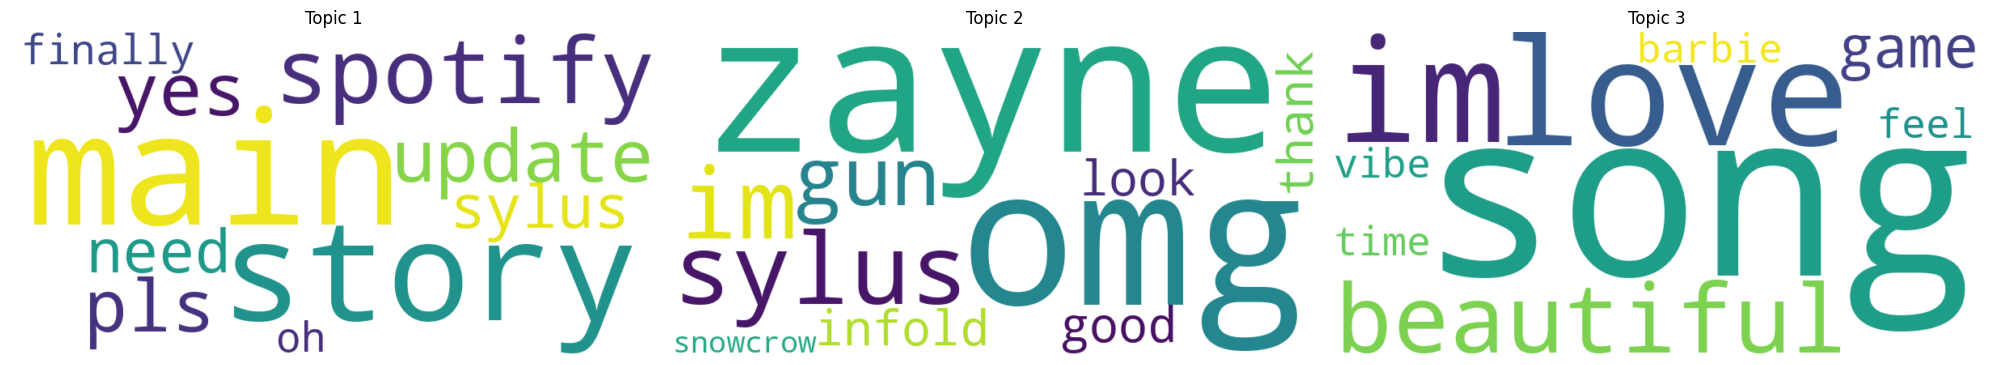

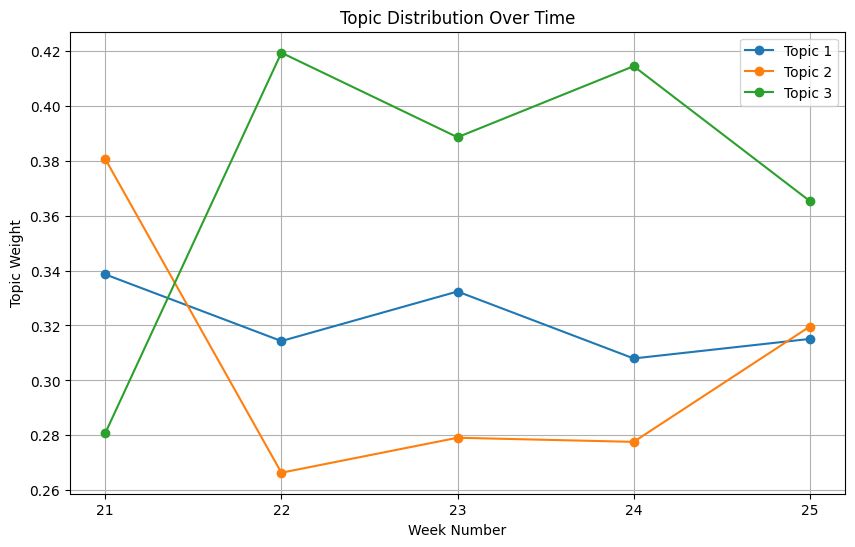

In [16]:
# LDA Topic Modeling
def perform_lda(texts, n_topics=3):
    # Create bag-of-words model
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    X = vectorizer.fit_transform(texts)

    # Apply LDA
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(X)

    # Get topic-word distribution
    feature_names = vectorizer.get_feature_names_out()
    topics = {}

    for topic_idx, topic in enumerate(lda.components_):
        top_words_idx = topic.argsort()[:-10-1:-1]  # Top 10 words per topic
        top_words = [feature_names[i] for i in top_words_idx]
        topics[f'Topic {topic_idx+1}'] = top_words

    # Get document-topic distribution
    doc_topics = lda.transform(X)
    df_topics = pd.DataFrame(doc_topics, columns=[f'Topic {i+1}' for i in range(n_topics)])

    return topics, df_topics

# Execute LDA
all_topics, all_doc_topics = perform_lda(data['processed_comment'])

# Time window analysis
time_windows = data['week'].unique()
time_windows.sort()
window_topics = {}

for window in time_windows:
    window_data = data[data['week'] == window]
    topics, _ = perform_lda(window_data['processed_comment'], n_topics=2)  # 2 topics per window
    window_topics[window] = topics

# Visualization: Word Clouds
def plot_wordclouds(topics):
    fig, axes = plt.subplots(1, len(topics), figsize=(20, 5))

    for i, (topic_name, words) in enumerate(topics.items()):
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(words))
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].set_title(topic_name)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Visualization: Topic trends over time
def plot_topic_trends(df, doc_topics):
    # Combine document-topic distribution with original data
    df_with_topics = pd.concat([df.reset_index(drop=True), doc_topics], axis=1)

    # Select only topic columns for aggregation
    topic_columns = [col for col in doc_topics.columns if 'Topic' in col]

    # Aggregate topic distribution by week, only for topic columns
    weekly_trends = df_with_topics.groupby('week')[topic_columns].mean()

    # Plot trends
    plt.figure(figsize=(10, 6))
    for topic in weekly_trends.columns:
        plt.plot(weekly_trends.index, weekly_trends[topic], marker='o', label=topic)

    plt.xlabel('Week Number')
    plt.ylabel('Topic Weight')
    plt.title('Topic Distribution Over Time')
    plt.legend()
    plt.grid(True)
    plt.xticks(weekly_trends.index)
    plt.show()

# Display results
print("Topic analysis for all comments:")
for topic, words in all_topics.items():
    print(f"{topic}: {', '.join(words)}")

print("\nTopic analysis by time window:")
for window, topics in window_topics.items():
    print(f"\nTopics for Week {window}:")
    for topic, words in topics.items():
        print(f"{topic}: {', '.join(words)}")

# Visualize results
plot_wordclouds(all_topics)
plot_topic_trends(data, all_doc_topics)